Cmax Initial: 13
Iter 1/50000 | T=99.0000 | Cmax Courant: 13 | Cmax Best: 13

--- Target Cmax (11) reached at iteration 822 ---

--- Fin du Recuit Simulé ---
Meilleur Cmax trouvé (Minimisation): 11
Temps d'exécution: 0.32 secondes

--- Résultats du meilleur Cmax ---


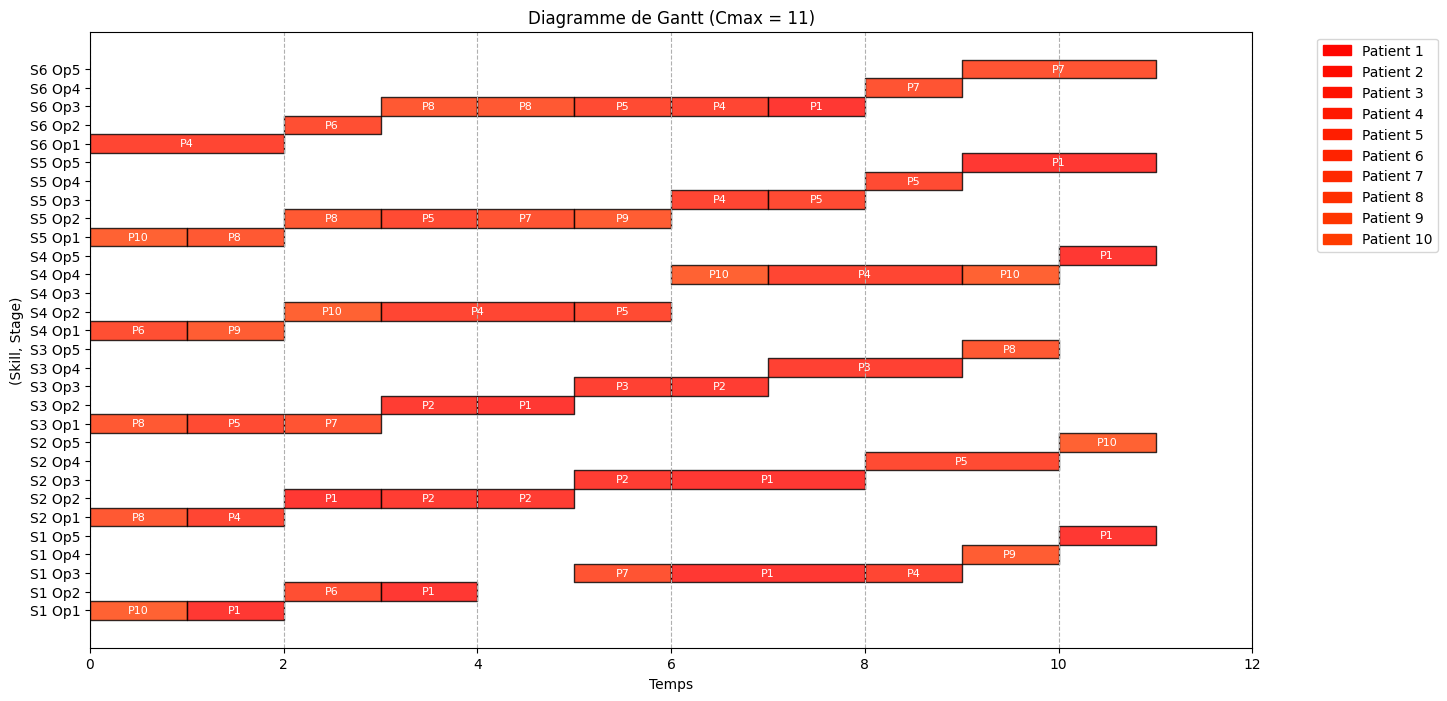

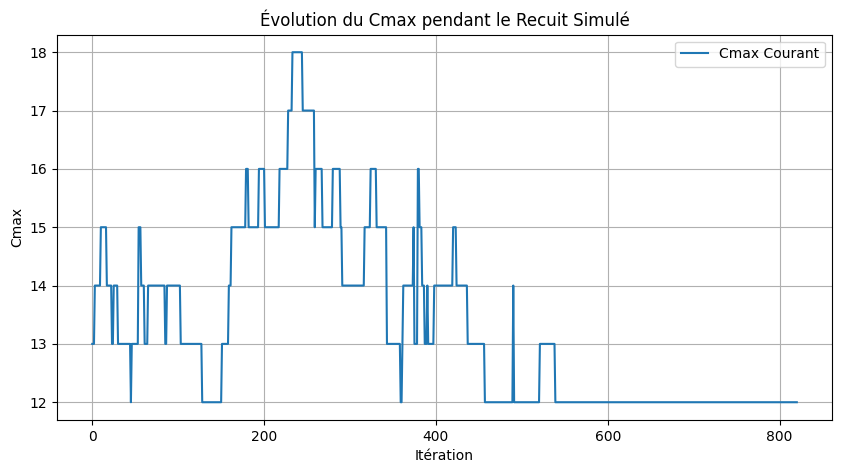

In [1]:
from copy import deepcopy
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from collections import defaultdict, namedtuple
import time

# --- Global Constants (Reverting to original instance) ---
SKILLS = [1, 2, 3, 4, 5, 6]
NUM_PATIENTS = 10          # Reverted to 10
MAX_OPS = 5          # Reverted to 5

# --- Original Hardcoded Data ---
DATA = {

    1: {
        1: [(1,2)], 2: [(1,1),(2,1)], 3: [(1,1),(3,1)],
        4: [(1,1),(2,2)], 5: [(4,1),(5,2),(6,1)],
    },
    2: {
        1: [(2,1),(3,1)], 2: [(2,1),(3,1)], 3: [(2,1)],
        4: [], 5: [],
    },
    3: {
        1: [(3,2)], 2: [(3,1)], 3: [], 4: [], 5: [],
    },
    4: {
        1: [(4,2)], 2: [(5,1),(6,1)], 3: [(6,2)],
        4: [(4,2)], 5: [(1,1),(2,1)],
    },
    5: {
        1: [(2,2)], 2: [(5,1)], 3: [(5,1),(6,1)],
        4: [(4,1),(5,1)], 5: [(3,1)],
    },
    6: {
        1: [(1,1)], 2: [(4,1)], 3: [(6,1)], 4: [], 5: [],
    },
    7: {
        1: [(6,2)], 2: [(1,1)], 3: [(5,1),(6,1)],
        4: [(3,1)], 5: [],
    },
    8: {
        1: [(3,1),(5,1)], 2: [(2,1),(5,1)], 3: [(3,1),(6,1)],
        4: [(6,1)], 5: [],
    },
    9: {
        1: [(5,1)], 2: [(4,1)], 3: [(1,1)], 4: [], 5: [],
    },
    10: {
        1: [(4,1)], 2: [(4,1),(5,1)], 3: [(1,1),(2,1)],
        4: [(4,1)], 5: [],
    },
}

# --- SA Parameters Adjusted for 10 Patients ---
T_INITIAL_BASE = 100.0      # Base temp - Increased for more exploration initially
ALPHA_FACTOR = 0.99     # Geometric decay factor - Increased for faster cooling
RESET_INTERVAL = 5000    # Reset interval
MAX_ITER = 50000     # Total iterations

# ---------------------------
# 1) Data Structure and Task Creation
# ---------------------------
def create_task(num_patients, data, max_ops):
    """Crée toutes les tâches et les structures d'indexation."""
    Task = namedtuple("Task", ["i", "j", "s", "p"])
    ALL_TASKS = []
    TASKS_BY_SKILL_STAGE = defaultdict(list)
    PATIENT_LAST_STAGE = {i: 0 for i in range(1, num_patients + 1)}

    for i in range(1, num_patients + 1):
        if i in data:
            for j in range(1, max_ops + 1):
                ops = data[i].get(j, [])
                if ops:
                    PATIENT_LAST_STAGE[i] = j
                for (s, p) in ops:
                    t = Task(i=i, j=j, s=s, p=p)
                    ALL_TASKS.append(t)
                    TASKS_BY_SKILL_STAGE[(s, j)].append(t)

    return ALL_TASKS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE

ALL_TASKS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE = create_task(NUM_PATIENTS, DATA, MAX_OPS)

# ---------------------------
# 2) Initial Sequence Building (Random Order)
# ---------------------------
def build_initial_sequences(skills, max_ops, tasks_by_skill_stage):
    """Construit une séquence initiale de tâches (ordre ALÉATOIRE)."""
    seq = {}
    for s in skills:
        for j in range(1, max_ops + 1):
            tasks = tasks_by_skill_stage.get((s, j), [])
            if not tasks:
                continue

            ordered_tasks = tasks[:]
            random.shuffle(ordered_tasks)

            seq[(s, j)] = ordered_tasks
    return seq

# ---------------------------
# 3) Evaluation Function (Fitness - Cmax)
# ---------------------------
def evaluate_cmax(sequences, num_patients, patient_last_stage, max_ops, skills):
    """
    Calcule le Cmax à partir des séquences de tâches.
    Contraintes:
    1. Ressource (skill 's') disponible.
    2. Ordre des opérations par patient (j-1 doit être terminé avant j).
    """
    # Temps de fin pour chaque patient/étape (pour la contrainte de précédence)
    patient_finish_time = defaultdict(lambda: 0) # Clé: (i, j) -> temps de fin

    # Temps de fin pour chaque compétence/ressource (pour la contrainte de ressource)
    resource_available_time = defaultdict(lambda: 0) # Clé: s -> temps de fin

    cmax = 0

    # Parcourez toutes les étapes j (de 1 à MAX_OPS)
    for j in range(1, max_ops + 1):
        # Parcourez toutes les ressources s
        for s in skills:
            # Obtenez la séquence pour (s, j)
            sequence_key = (s, j)
            if sequence_key in sequences:
                tasks = sequences[sequence_key]

                # Traitez chaque tâche dans l'ordre de la séquence
                for task in tasks:
                    i, j_current, s_current, p = task.i, task.j, task.s, task.p

                    # 1. Contrainte de précédence: Attendre que l'étape précédente (j-1) soit terminée.
                    # Si j > 1, on doit attendre le temps de fin de (i, j-1)
                    required_previous_finish = patient_finish_time.get((i, j_current - 1), 0)

                    # 2. Contrainte de ressource: Attendre que la ressource (s) soit disponible.
                    required_resource_available = resource_available_time[s_current]

                    # Le temps de début (start time) est le maximum des deux contraintes
                    start_time = max(required_previous_finish, required_resource_available)

                    # Temps de fin (finish time)
                    finish_time = start_time + p

                    # Mettre à jour les temps de fin
                    patient_finish_time[(i, j_current)] = finish_time
                    resource_available_time[s_current] = finish_time

                    # Mettre à jour le Cmax
                    cmax = max(cmax, finish_time)

    # Remarque: Le Cmax est la dernière étape terminée pour tous les patients.
    # Cmax = max(patient_finish_time.get((i, patient_last_stage[i]), 0) for i in range(1, num_patients + 1))
    # Puisque nous parcourons toutes les tâches, le cmax simple est correct.

    return cmax

# ---------------------------
# 4) Neighborhood Generation (Move)
# ---------------------------
def generate_neighbor(current_sequences, skills, max_ops):
    """
    Génère un état voisin en échangeant deux tâches au hasard.
    Peut échanger:
    1. Deux tâches dans la même séquence (skill, stage).
    2. Deux tâches de stages différents mais du même skill.
    """
    new_sequences = deepcopy(current_sequences)

    move_type = random.choice(["swap_within_stage", "swap_between_stages"])

    if move_type == "swap_within_stage":
        # Swap within the same skill, same stage (original move)
        available_keys = [k for k, v in new_sequences.items() if len(v) >= 2]
        if not available_keys:
            return new_sequences

        s, j = random.choice(available_keys)
        tasks_list = new_sequences[(s, j)]

        idx1, idx2 = random.sample(range(len(tasks_list)), 2)
        tasks_list[idx1], tasks_list[idx2] = tasks_list[idx2], tasks_list[idx1]

    elif move_type == "swap_between_stages":
        # Swap between different stages, same skill
        # Find skills that have tasks in at least two different stages
        skills_with_multiple_stages = []
        for s in skills:
            stages_with_tasks = [j for j in range(1, max_ops + 1) if (s, j) in new_sequences and new_sequences[(s, j)]]
            if len(stages_with_multiple_stages) >= 2:
                skills_with_multiple_stages.append(s)

        if not skills_with_multiple_stages:
            # If no skill has tasks in multiple stages, fall back to swap within stage
            return generate_neighbor(current_sequences, skills, max_ops) # Recursive call for simplicity

        s = random.choice(skills_with_multiple_stages)
        stages_with_tasks = [j for j in range(1, max_ops + 1) if (s, j) in new_sequences and new_sequences[(s, j)]]

        # Choose two different stages for this skill
        j1, j2 = random.sample(stages_with_tasks, 2)

        list1 = new_sequences[(s, j1)]
        list2 = new_sequences[(s, j2)]

        # Choose one task from each stage
        task_idx1 = random.choice(range(len(list1)))
        task_idx2 = random.choice(range(len(list2)))

        task1 = list1[task_idx1]
        task2 = list2[task_idx2]

        # Swap the tasks in the lists
        list1[task_idx1] = task2._replace(j=j1) # Update stage of swapped task
        list2[task_idx2] = task1._replace(j=j2) # Update stage of swapped task

        new_sequences[(s, j1)] = list1
        new_sequences[(s, j2)] = list2


    return new_sequences

# ---------------------------
# 5) Simulated Annealing Algorithm (SA)
# ---------------------------
def simulated_annealing(
    t_initial_base, alpha_factor, reset_interval, max_iter,
    skills, max_ops, tasks_by_skill_stage, patient_last_stage
):
    # 1. Initialisation
    current_sequences = build_initial_sequences(skills, max_ops, tasks_by_skill_stage)
    current_cmax = evaluate_cmax(current_sequences, NUM_PATIENTS, patient_last_stage, MAX_OPS, skills)

    # Le SA est utilisé ici pour MINIMISER le CMAX
    best_sequences = deepcopy(current_sequences)
    best_cmax = current_cmax

    T = t_initial_base # Température initiale

    history_cmax = []

    print(f"Cmax Initial: {current_cmax}")

    # 2. Boucle principale
    for k in range(1, max_iter + 1):
        # Reset de la température pour l'exploration (if necessary)
        if k % reset_interval == 0:
            T = t_initial_base  # Réchauffage

        # 2.1 Générer un voisin
        neighbor_sequences = generate_neighbor(current_sequences, skills, max_ops)
        neighbor_cmax = evaluate_cmax(neighbor_sequences, NUM_PATIENTS, patient_last_stage, MAX_OPS, skills)

        # 2.2 Calculer la différence d'énergie (objectif: minimiser Cmax)
        # Delta = Cmax_voisin - Cmax_courant
        delta = neighbor_cmax - current_cmax

        # 2.3 Critère d'acceptation (Metropolis for Minimization)
        # If the neighbor is better (delta < 0) or accepted by probability (exploration)
        if delta < 0:
            # The neighbor is better
            current_cmax = neighbor_cmax
            current_sequences = neighbor_sequences
        elif T > 0:
            # The neighbor is worse (delta > 0), accept with probability e^(-delta/T)
            acceptance_prob = math.exp(-delta / T)
            if random.random() < acceptance_prob:
                current_cmax = neighbor_cmax
                current_sequences = neighbor_sequences

        # 2.4 Mettre à jour la meilleure solution trouvée
        # NOTE: We MINIMIZE the Cmax, so < is the correct comparison
        if current_cmax < best_cmax:
            best_cmax = current_cmax
            best_sequences = deepcopy(current_sequences)

        # Check if target Cmax is reached
        if best_cmax <= 11:
            print(f"\n--- Target Cmax (11) reached at iteration {k} ---")
            break

        # 2.5 Refroidissement (if T > 0)
        if T > 0:
            T *= alpha_factor

        history_cmax.append(current_cmax)

        # Display progress
        if k % 1000 == 0 or k == 1:
             print(f"Iter {k}/{max_iter} | T={T:.4f} | Cmax Courant: {current_cmax} | Cmax Best: {best_cmax}")


    print(f"\n--- Fin du Recuit Simulé ---")
    print(f"Meilleur Cmax trouvé (Minimisation): {best_cmax}")

    return best_sequences, best_cmax, history_cmax

# ---------------------------
# 6) Visualisation (Optionnel)
# ---------------------------
def plot_gantt(sequences, num_patients, patient_last_stage, max_ops, skills):
    """Génère un graphique de Gantt."""
    # Recalculer les temps de début/fin pour le tracé
    patient_finish_time = defaultdict(lambda: 0)
    resource_available_time = defaultdict(lambda: 0)
    task_schedule = []

    max_cmax = 0

    # Couleurs pour les patients
    colors = plt.colormaps['hsv'](range(num_patients + 1))


    for j in range(1, max_ops + 1):
        for s in skills:
            sequence_key = (s, j)
            if sequence_key in sequences:
                tasks = sequences[sequence_key]
                for task in tasks:
                    i, j_current, s_current, p = task.i, task.j, task.s, task.p
                    required_previous_finish = patient_finish_time.get((i, j_current - 1), 0)
                    required_resource_available = resource_available_time[s_current]
                    start_time = max(required_previous_finish, required_resource_available)
                    finish_time = start_time + p

                    patient_finish_time[(i, j_current)] = finish_time
                    resource_available_time[s_current] = finish_time
                    max_cmax = max(max_cmax, finish_time)

                    task_schedule.append({
                        "s": s_current, "i": i, "j": j_current, "start": start_time, "duration": p, "color": colors[i]
                    })

    # Tracé
    fig, ax = plt.subplots(figsize=(15, 8))

    y_ticks_labels = []
    y_ticks_pos = []
    current_y = 0

    for s in skills:
        for j in range(1, max_ops + 1):
            y_ticks_labels.append(f"S{s} Op{j}")
            y_ticks_pos.append(current_y + 0.5)
            current_y += 1

    # Dessiner les barres
    for task in task_schedule:
        # Calculez la position Y
        # Index: (s-1) * MAX_OPS + (j-1)
        y_pos_index = (task["s"] - 1) * max_ops + (task["j"] - 1)
        y_start = y_pos_index

        ax.broken_barh([(task["start"], task["duration"])], (y_start, 1),
                       facecolors=task["color"], edgecolor='black', alpha=0.8)
        # Ajouter le label du patient
        ax.text(task["start"] + task["duration"] / 2, y_start + 0.5,
                f"P{task['i']}", ha='center', va='center', color='white', fontsize=8)

    # Configuration de l'axe Y
    ax.set_yticks(y_ticks_pos)
    ax.set_yticklabels(y_ticks_labels)
    ax.set_xlabel("Temps")
    ax.set_ylabel("(Skill, Stage)")
    ax.set_title(f"Diagramme de Gantt (Cmax = {max_cmax})")
    ax.grid(True, axis='x', linestyle='--')
    ax.set_xlim(0, max_cmax + 1)

    # Légende
    legend_patches = [Patch(color=colors[i], label=f"Patient {i}") for i in range(1, num_patients + 1)]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

def plot_history(history_cmax):
    """Affiche l'historique de l'évolution du Cmax."""
    plt.figure(figsize=(10, 5))
    plt.plot(history_cmax, label="Cmax Courant")
    plt.title("Évolution du Cmax pendant le Recuit Simulé")
    plt.xlabel("Itération")
    plt.ylabel("Cmax")
    plt.grid(True)
    plt.legend()
    plt.show()

# ---------------------------
# 7) Exécution
# ---------------------------
start_time = time.time()

# Exécution de l'algorithme SA
best_seq, best_cmax, history = simulated_annealing(
    T_INITIAL_BASE, ALPHA_FACTOR, RESET_INTERVAL, MAX_ITER,
    SKILLS, MAX_OPS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE
)

end_time = time.time()
print(f"Temps d'exécution: {end_time - start_time:.2f} secondes")

print("\n--- Résultats du meilleur Cmax ---")
# Affichage d'une partie des résultats (peut être très long)
# print("Meilleures séquences:", best_seq)

# Optionnel: Tracer le Gantt
plot_gantt(best_seq, NUM_PATIENTS, PATIENT_LAST_STAGE, MAX_OPS, SKILLS)

# Optionnel: Tracer l'historique
plot_history(history)

In [2]:
def _patient_colors(num_patients):
    """Palette stable pour n patients (tab20)."""
    cmap = plt.colormaps.get_cmap("tab20")
    n = min(20, num_patients)
    return {i+1: cmap(i / (n-1)) if n > 1 else cmap(0) for i in range(num_patients)}

def build_gantt_data(task_times, skills):
    """
    Re-formate task_times -> dict skill -> liste d'items triés
    """
    by_skill = {s: [] for s in skills}
    horizon = 0
    for (i, j, s), (start, finish, p) in task_times.items():
        by_skill[s].append({
            "start": start, "end": finish, "dur": p,
            "patient": i, "op": j
        })
        horizon = max(horizon, finish)

    for s in skills:
        by_skill[s].sort(key=lambda x: (x["start"], x["patient"], x["op"]))

    return by_skill, horizon

def plot_gantt(task_times, skills, num_patients, title="Gantt – Planning par compétence",
               figsize=None, annotate=True, save_path=None, dpi=150):
    """Génère et affiche le diagramme de Gantt."""
    by_skill, horizon = build_gantt_data(task_times, skills)

    if horizon == 0:
        print("Makespan is 0. Cannot plot Gantt chart.")
        return

    colors = _patient_colors(num_patients)

    if figsize is None:
        figsize = (max(10, horizon * 0.4), 1.2 * len(skills) + 2)

    fig, ax = plt.subplots(figsize=figsize)

    lane_height = 0.8
    y_gap = 0.6
    y_positions = {s: (len(skills) - idx - 1) * (lane_height + y_gap) for idx, s in enumerate(skills)}
    ymin = -0.5
    ymax = max(y_positions.values()) + lane_height + 0.5

    for s in skills:
        y = y_positions[s]
        ax.add_patch(Rectangle((0, y - 0.1), horizon, lane_height + 0.2,
                               facecolor=(0, 0, 0, 0.03), edgecolor="none"))
        for it in by_skill[s]:
            start = it["start"]
            dur = it["dur"]
            i = it["patient"]
            j = it["op"]

            ax.broken_barh([(start, dur)], (y, lane_height),
                           facecolors=colors[i], edgecolor='black', alpha=0.8)
            if annotate:
                ax.text(start + dur / 2, y + lane_height / 2,
                        f"P{i}-Op{j}", ha='center', va='center', color='white', fontsize=8)


    # Corrected y-ticks calculation
    ax.set_yticks([y + lane_height / 2 for y in y_positions.values()])
    ax.set_yticklabels([f"Skill {s}" for s in skills])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, horizon)
    ax.set_xlabel("Time")
    ax.set_title(title)
    ax.grid(True, axis='x', linestyle='--')

    # Add legend
    legend_patches = [Patch(color=colors[i], label=f"Patient {i}") for i in range(1, num_patients + 1)]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi)
    plt.show()

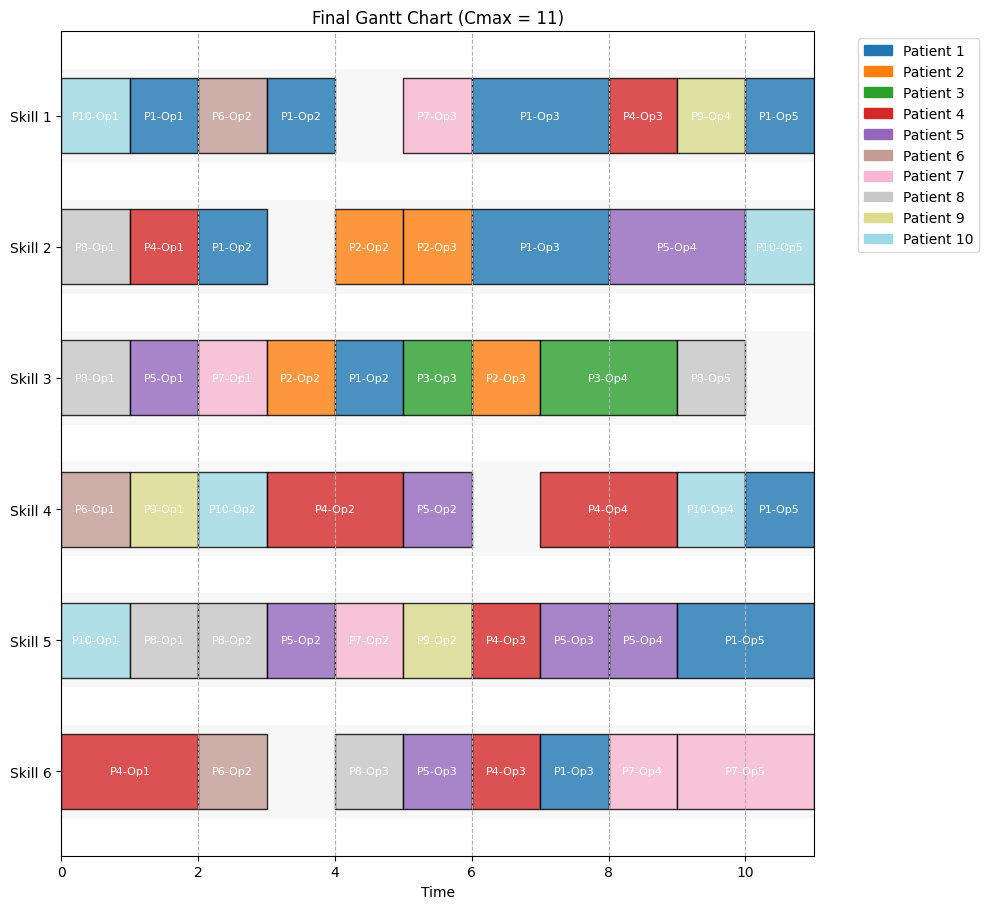

In [3]:
def build_gantt_data_from_sequences(sequences, skills):
    """
    Builds the task_times dictionary from the sequences dictionary.
    """
    task_times = {}
    patient_finish_time = defaultdict(lambda: 0)
    resource_available_time = defaultdict(lambda: 0)

    for j in range(1, MAX_OPS + 1):
        for s in skills:
            sequence_key = (s, j)
            if sequence_key in sequences:
                tasks = sequences[sequence_key]
                for task in tasks:
                    i, j_current, s_current, p = task.i, task.j, task.s, task.p
                    required_previous_finish = patient_finish_time.get((i, j_current - 1), 0)
                    required_resource_available = resource_available_time[s_current]
                    start_time = max(required_previous_finish, required_resource_available)
                    finish_time = start_time + p

                    patient_finish_time[(i, j_current)] = finish_time
                    resource_available_time[s_current] = finish_time

                    task_times[(i, j_current, s_current)] = (start_time, finish_time, p)

    return task_times

# Build task_times from the best_seq found by SA
task_times = build_gantt_data_from_sequences(best_seq, SKILLS)

# Visualize the final result using the provided plot_gantt function
plot_gantt(task_times, SKILLS, NUM_PATIENTS, title=f"Final Gantt Chart (Cmax = {best_cmax})")